# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
def pretty_display(df, title="Таблица"):
    styled_df = df.head(5).style \
        .set_table_styles(
            [{'selector': 'th', 'props': [('text-align', 'center')]}]
        ) \
        .set_properties(**{'text-align': 'center'}) \
        .highlight_null(null_color='lightgray') \
        .set_caption(title)
    
    display(styled_df)

In [4]:
pretty_display(geo_data_0, "Первые 5 строк таблицы geo_data_0")
pretty_display(geo_data_1, "Первые 5 строк таблицы geo_data_1")
pretty_display(geo_data_2, "Первые 5 строк таблицы geo_data_2")

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [5]:
display(geo_data_0.info())
display(geo_data_1.info())
display(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [6]:
def check_duplicates(df, name):
    dup_count = df.duplicated().sum()
    print(f"В {name}: {dup_count} дубликатов")
    if dup_count > 0:
        print(df[df.duplicated()].head())
    print('-' * 50)

In [7]:
missing_values = geo_data_0.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values
check_duplicates(geo_data_0, "geo_data_0")
geo_data_0 = geo_data_0.drop_duplicates().reset_index(drop=True)

В geo_data_0: 0 дубликатов
--------------------------------------------------


In [8]:
missing_values = geo_data_1.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values
check_duplicates(geo_data_1, "geo_data_1")
geo_data_1 = geo_data_1.drop_duplicates().reset_index(drop=True)

В geo_data_1: 0 дубликатов
--------------------------------------------------


In [9]:
missing_values = geo_data_2.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values
check_duplicates(geo_data_2, "geo_data_2")
geo_data_2 = geo_data_2.drop_duplicates().reset_index(drop=True)

В geo_data_2: 0 дубликатов
--------------------------------------------------


In [10]:
print(geo_data_0.isnull().sum())
print(geo_data_1.isnull().sum())
print(geo_data_2.isnull().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Первичный анализ показал что данные имеют одинаковую структуру, все три файла имеют следующие столбцы:

- id — уникальный идентификатор скважины;

- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

- product — объём запасов в скважине (тыс. баррелей).

В файлах не обнаружено дубликатов и пропусков.

<b>Исследовательский анализ данных</b>

In [11]:
def plot_numeric_features(df, features=None, bins=30):
  
    if features is None:
        features = df.select_dtypes(include='number').columns
    
    for col in features:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), bins=bins, kde=True, color='skyblue')
        plt.title(f'Распределение признака: {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color='lightgreen')
        plt.title(f'Boxplot признака: {col}')
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()

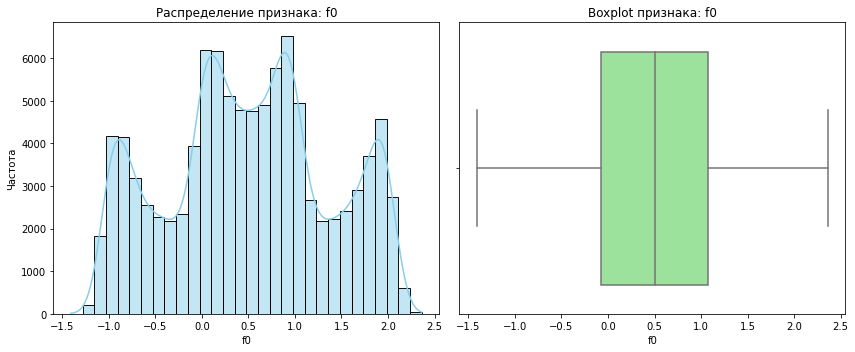

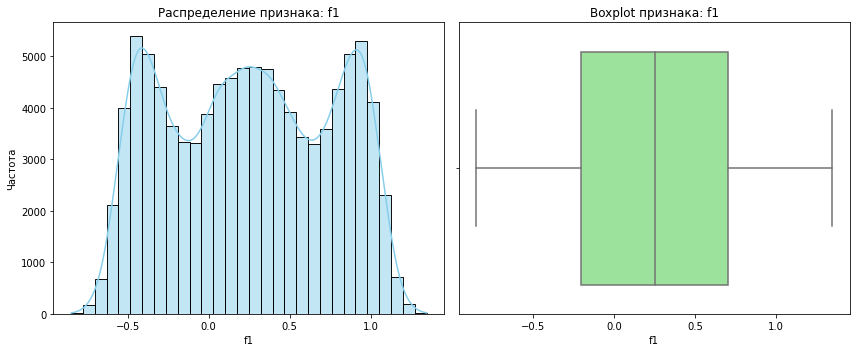

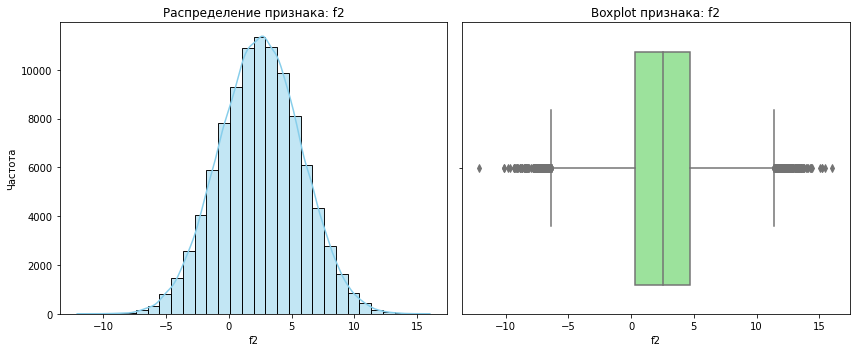

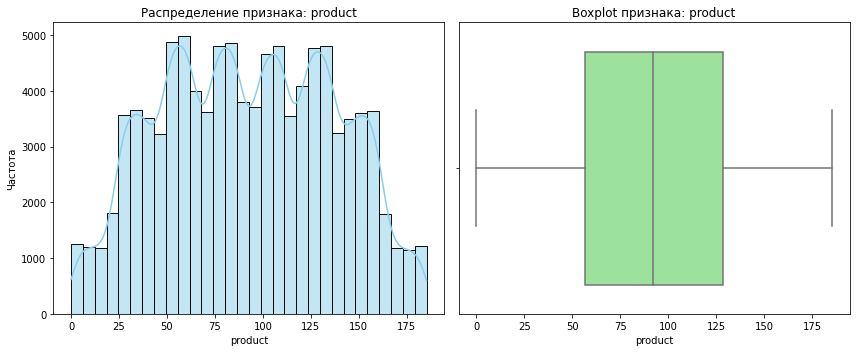

In [12]:
geo_data_0_with_no_id = geo_data_0.drop(['id'], axis=1)

plot_numeric_features(geo_data_0_with_no_id)

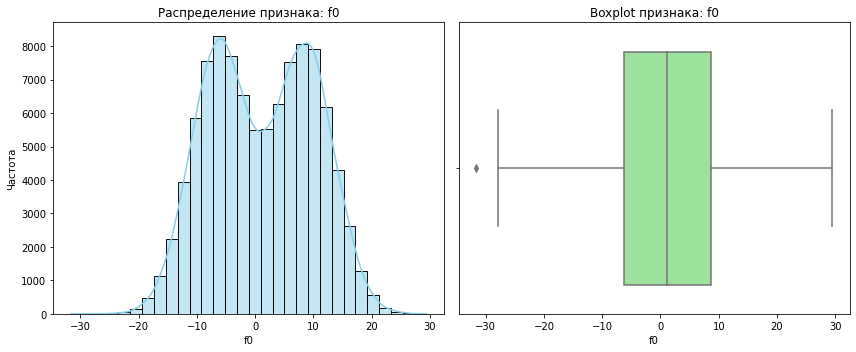

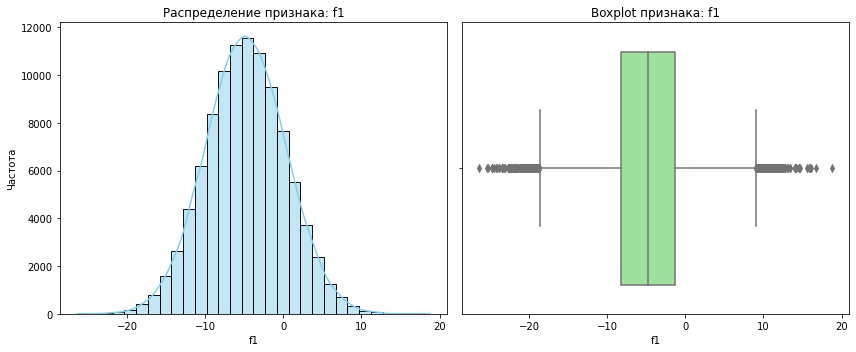

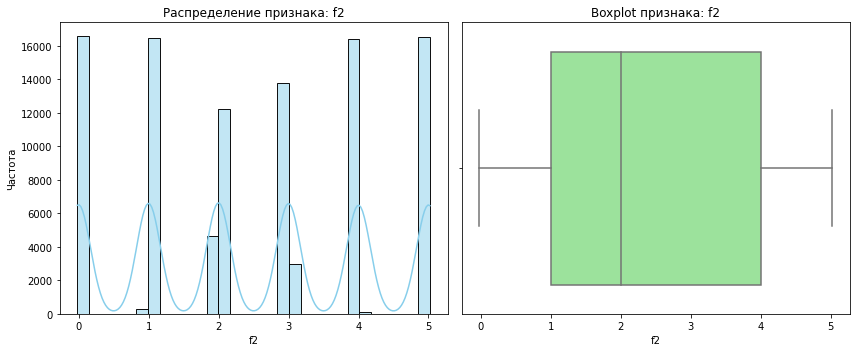

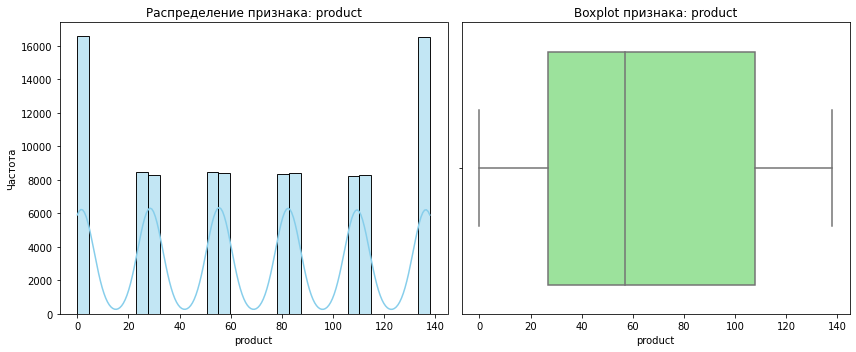

In [13]:
geo_data_1_with_no_id = geo_data_1.drop(['id'], axis=1)

plot_numeric_features(geo_data_1_with_no_id)

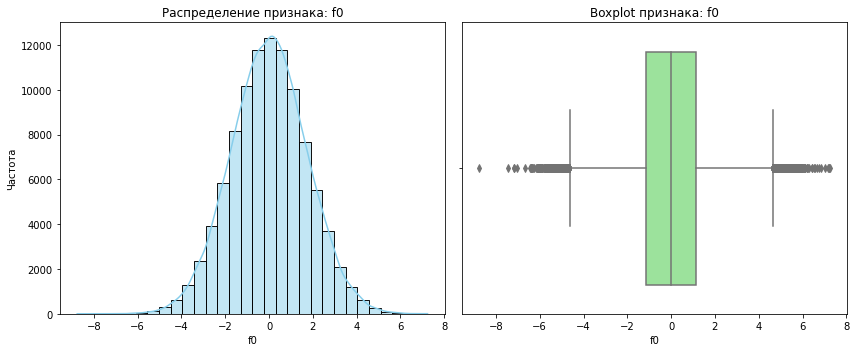

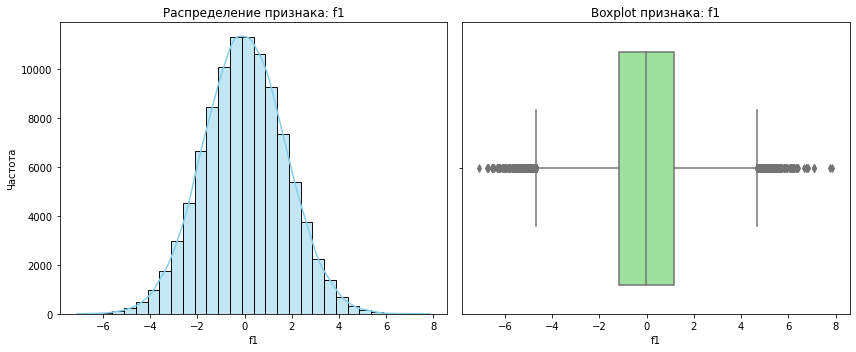

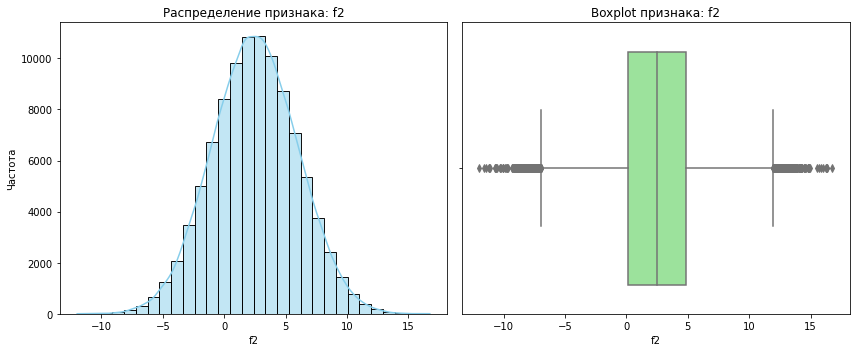

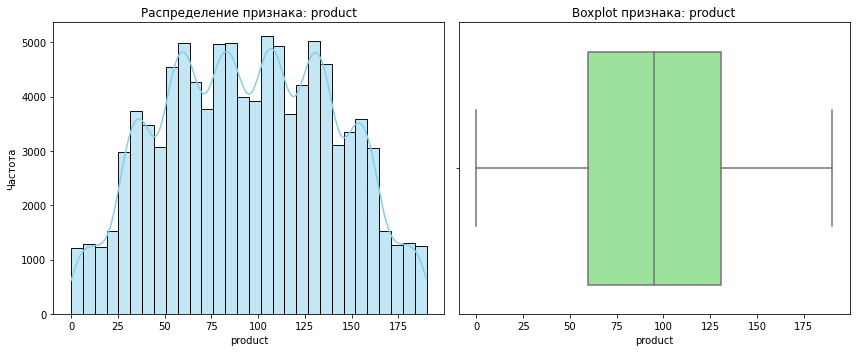

In [14]:
geo_data_2_with_no_id = geo_data_2.drop(['id'], axis=1)

plot_numeric_features(geo_data_2_with_no_id)

Визуализация признаков показала что средняя продуктивность скважин находиться на уровне:
- на первом участке - 90 бареллей. 
- на втором - 58 бареллей. 
- на третьем 90 бареллей.

Стоит отметить что распределение признаков на втором участке дискретны, в сравнении с первым и третьим участком.

## Обучение и проверка модели

In [15]:
def predict_oil_productivity(df, target_col='product', drop_cols=['id'], test_size=0.25, random_state=42):
    
    # Отделяем признаки и целевую переменную
    X = df.drop(columns=drop_cols + [target_col])
    y = df[target_col]

    # Разделение на обучающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Масштабирование признаков
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Обучение модели
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Предсказания
    y_pred = model.predict(X_valid_scaled)

    # Результаты и метрики
    results = pd.DataFrame({
        'real_product': y_valid.values,
        'predicted_product': y_pred
    })

    rmse = mean_squared_error(y_valid, y_pred) ** 0.5
    mean_pred = y_pred.mean()
    total_pred = y_pred.sum()

    return results, rmse, mean_pred, total_pred, model

In [16]:
results_0, rmse_0, mean_pred_0, total_pred_0, model_0 = predict_oil_productivity(geo_data_0)

print("RMSE:", rmse_0)
print("Среднее предсказание сырья:", mean_pred_0)
print("Суммарный объём нефти (предсказанный):", total_pred_0)
print(results_0.head())

RMSE: 37.75660035026169
Среднее предсказание сырья: 92.39879990657768
Суммарный объём нефти (предсказанный): 2309969.997664442
   real_product  predicted_product
0    122.073350         101.901017
1     48.738540          78.217774
2    131.338088         115.266901
3     88.327757         105.618618
4     36.959266          97.980185


In [17]:
results_1, rmse_1, mean_pred_1, total_pred_1, model_1 = predict_oil_productivity(geo_data_1)

print("RMSE:", rmse_1)
print("Среднее предсказание сырья:", mean_pred_1)
print("Суммарный объём нефти (предсказанный):", total_pred_1)
print(results_1.head())

RMSE: 0.8902801001028846
Среднее предсказание сырья: 68.7128780391376
Суммарный объём нефти (предсказанный): 1717821.9509784402
   real_product  predicted_product
0      0.000000           0.844738
1     53.906522          52.921612
2    134.766305         135.110385
3    107.813044         109.494863
4      0.000000          -0.047292


In [18]:
results_2, rmse_2, mean_pred_2, total_pred_2, model_2 = predict_oil_productivity(geo_data_2)

print("RMSE:", rmse_2)
print("Среднее предсказание сырья:", mean_pred_2)
print("Суммарный объём нефти (предсказанный):", total_pred_2)
print(results_2.head())

RMSE: 40.145872311342174
Среднее предсказание сырья: 94.77102387765939
Суммарный объём нефти (предсказанный): 2369275.5969414846
   real_product  predicted_product
0    117.441301          98.301916
1     47.841249         101.592461
2     45.883483          52.449099
3    139.014608         109.922127
4     84.004276          72.411847


Анализ RMSE показал что масштабирование не влияет на качество модели, между признаками f0, f1, f2 и целевым признаком нет сильной корреляции. На втором участке RMSE (0.89) модель показывает очень плохие результаты, распределение признаков там имеет дискретные характеристики.

## Подготовка к расчёту прибыли

In [19]:
total_budget = 10_000_000_000
best_well = 200
revenue_gross = 450_000

In [20]:
n = total_budget/ revenue_gross
print(f'Точка безубыточности: {int(n):,} тыс. баррелей')
print(f'Точка безубыточности: тыс. баррелей', np.ceil(n/best_well))

Точка безубыточности: 22,222 тыс. баррелей
Точка безубыточности: тыс. баррелей 112.0


In [21]:
print('Средний объем нефти на скважину в первом участке', geo_data_0['product'].mean())
print('Средний объем нефти во втором участве', geo_data_1['product'].mean())
print('Средний объем нефти в третьем участке', geo_data_2['product'].mean())

Средний объем нефти на скважину в первом участке 92.50000000000001
Средний объем нефти во втором участве 68.82500000000002
Средний объем нефти в третьем участке 95.00000000000004


Расчеты показали что для того что бы скважина себя окупила требуется 112 тыс баррелей нефти со скважины, к сожалениею среднее значение продуктивности по всем трем участкам ниже, особенно на втором участке.

## Расчёт прибыли и рисков 

In [22]:
state = np.random.RandomState(42)

def revenue(probabilities, target):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:200]
    revenue = selected.sum() * revenue_gross
    return revenue - total_budget

In [23]:
def bootstrap(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=500)
        probs_sample = probs[target_sample.index]
        profit = revenue(probs_sample, target)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [24]:
avg_0, low_0, upper_0, risk_val_0 = bootstrap(results_0['real_product'], results_0['predicted_product'])

print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(avg_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(low_0, upper_0))
print('Процент риска {:.2%}'.format(risk_val_0))

Средняя прибыль по региону = 399575478.05 тыс.руб.
95% доверительный интервал от -110467895.33 до 897460327.72 тыс.руб.
Процент риска 6.00%


In [25]:
avg_1, low_1, upper_1, risk_val_1 = bootstrap(results_1['real_product'], results_1['predicted_product'])

print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(avg_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(low_1, upper_1))
print('Процент риска {:.2%}'.format(risk_val_1))

Средняя прибыль по региону = 452576594.29 тыс.руб.
95% доверительный интервал от 52309409.80 до 830146313.26 тыс.руб.
Процент риска 0.90%


In [26]:
avg_2, low_2, upper_2, risk_val_2 = bootstrap(results_2['real_product'], results_2['predicted_product'])

print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(avg_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(low_2, upper_2))
print('Процент риска {:.2%}'.format(risk_val_2))

Средняя прибыль по региону = 378705903.66 тыс.руб.
95% доверительный интервал от -127779434.99 до 907923483.22 тыс.руб.
Процент риска 7.50%


Наиболее подходящим регионом для бурения скважин является регион №2, несмотря на среднее значение закасов в скважинах, и некоторую дискретность данных. Анализ показал что наиболее перспективные точки находятся в данном регионе.